In [1]:
import requests
import urllib3
import socket

import pandas as pd
import pandas_profiling

from datetime import date, datetime
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## force ipv4 since default ipv6 is slow at first connection on cwb's server
requests.packages.urllib3.util.connection.allowed_gai_family = lambda : socket.AF_INET

# matplotlib.rcParams['font.family'] = ['Heiti TC']

# def rmax(maxrow: int=50):
#     pd.set_option('display.max_rows', maxrow)
# def cmax(maxcol: int=50):
#     pd.set_option('display.max_columns', maxcol)
# from custom.exp1 import *
from custom.weather import *

%load_ext autoreload
%autoreload 2

## debug and log request calls

In [2]:
# import logging
# import http.client

# http.client.HTTPConnection.debuglevel = 1
# # You must initialize logging, otherwise you'll not see debug output.
# logging.basicConfig()
# logging.getLogger().setLevel(logging.DEBUG)
# requests_log = logging.getLogger("requests.packages.urllib3")
# requests_log.setLevel(logging.DEBUG)
# requests_log.propagate = True

## Get all station codes (所有測站代碼）

In [ ]:
url = "http://e-service.cwb.gov.tw/wdps/obs/state.htm"
df = pd.read_html(url);df

In [ ]:
df = pd.DataFrame(df[0]);df

In [4]:
df.head(10)

站號      站名  海拔高度(m)          經度         緯度   城市                  地址  \
0  466850  五分山雷達站    756.0  121.781205  25.071182  新北市        瑞芳區靜安路四段1巷1號   
1  466880      板橋      9.7  121.442017  24.997647  新北市     板橋區大觀路二段265巷62號   
2  466900      淡水     19.0  121.448906  25.164889  新北市        淡水區中正東路42巷6號   
3  466910      鞍部    837.6  121.529731  25.182586  臺北市      北投區陽明山竹子湖路111號   
4  466920      臺北      5.3  121.514853  25.037658  臺北市           中正區公園路64號   
5  466930     竹子湖    607.1  121.544547  25.162078  臺北市        北投區陽明山竹子湖路2號   
6  466940      基隆     26.7  121.740475  25.133314  基隆市  仁愛區港西街6號6樓(海港大樓6樓)   
7  466950     彭佳嶼    101.7  122.079744  25.627975  基隆市              中正區彭佳嶼   
8  466990      花蓮     16.1  121.613275  23.975128  花蓮縣           花蓮市花崗街24號   
9  467050      新屋     20.6  121.047486  25.006744  桃園市        新屋區東興路二段946號   

       資料起始日期  撤站日期                                                 備註  原站號  \
0  1998/07/01   NaN                                        本站只有雷達觀測資料。  NaN   
1  1972/03/01   NaN  原為探空站，自2002年開始進行氣象觀測。因受附近興建合宜住宅影響，日照觀測自民國104年起...  NaN   
2  1942/01/01   NaN                                                NaN  NaN   
3  1937/01/01   NaN                                                NaN  NaN   
4  1896/01/01   NaN  2014至2015氣候年報之氣壓計海面上高度應為30.3m(2014/10/25搬遷，6.6...  NaN   
5  1937/01/01   NaN                                                NaN  NaN   
6  1946/01/01   NaN                                                NaN  NaN   
7  1910/01/01   NaN                                                NaN  NaN   
8  1910/01/01   NaN                                                NaN  NaN   
9  2013/07/01   NaN  座標及高度於2013/10/09更正。2020/01/01至2020/02/15因施工部分觀...  NaN   

   新站號  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN  
5  NaN  
6  NaN  
7  NaN  
8  NaN  
9  NaN

## Download weather data

In [4]:
%%time
tp = get_historical_weather('466920', y_start=2015, y_end=2020, verbose=False)
yl = get_historical_weather('467080', y_start=2015, y_end=2020, verbose=False)
sa = get_historical_weather('467060', y_start=2015, y_end=2020, verbose=False)

# # hc = get_historical_weather('467571', y_start=2010, y_end=2019, verbose=False)

CPU times: user 7.54 s, sys: 275 ms, total: 7.82 s
Wall time: 24.7 s


In [45]:
# kl = get_historical_weather('466940', y_start=2010, y_end=2019, verbose=False)
# ts = get_historical_weather('466900', y_start=2010, y_end=2019, verbose=False)

# bq = get_historical_weather('466880', y_start=2010, y_end=2019, verbose=False)

In [13]:
# pjy = get_historical_weather('466950', y_start=2010, y_end=2019, verbose=False)
# zzu = get_historical_weather('466930', y_start=2010, y_end=2019, verbose=False)
# ab =  get_historical_weather('466910', y_start=2010, y_end=2019, verbose=False)

## Plot wind directions

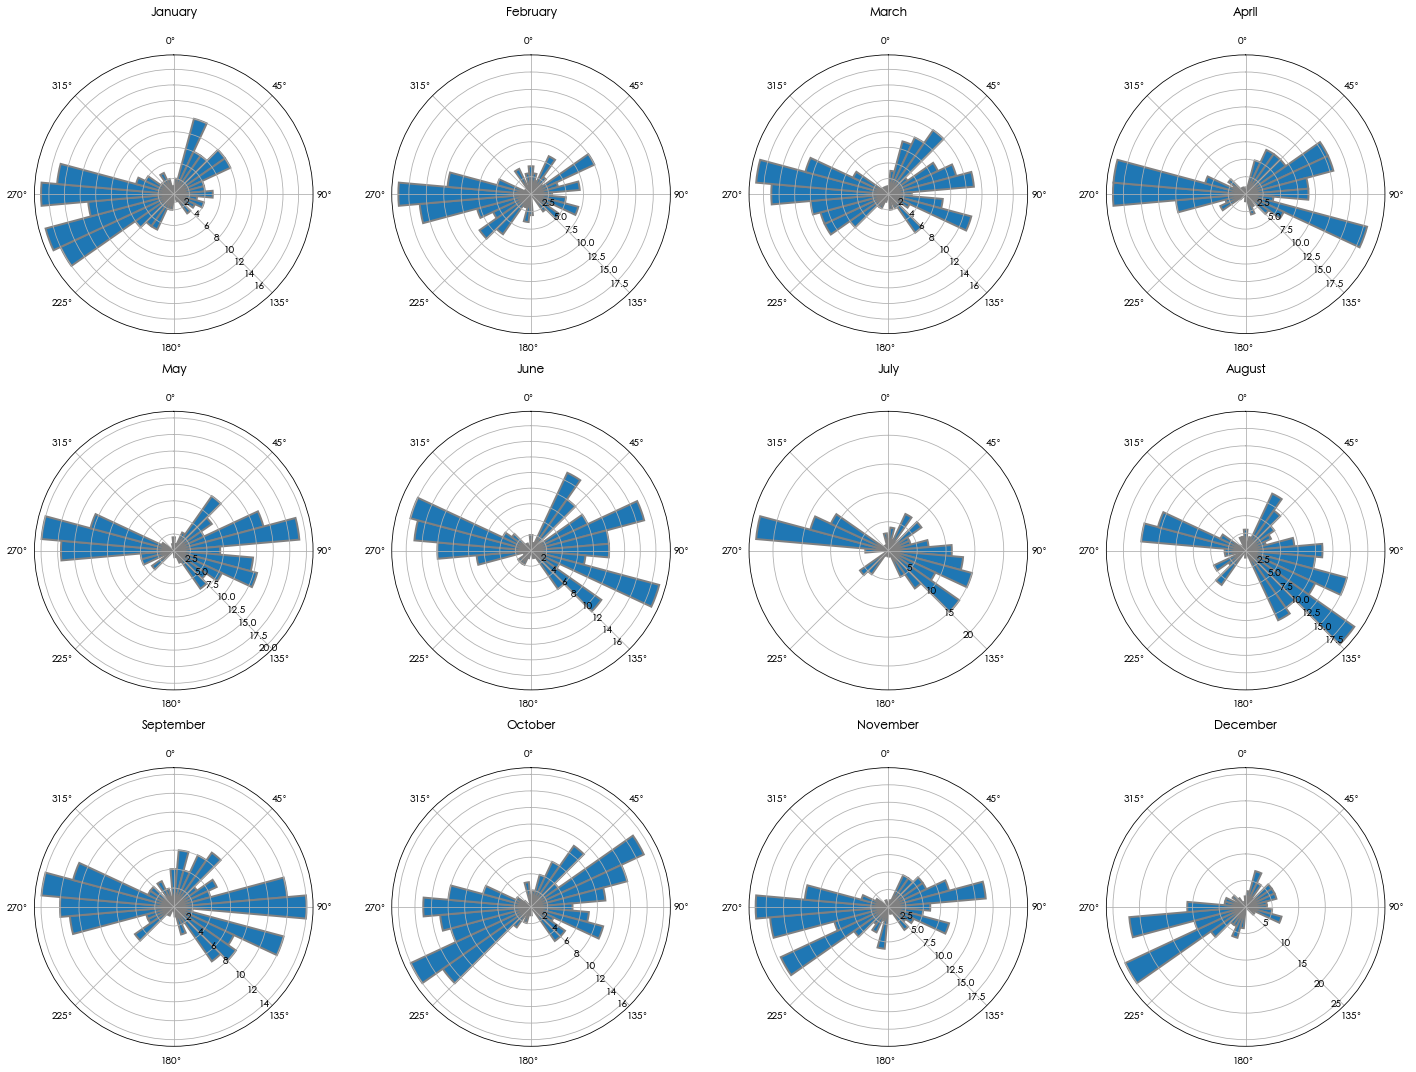

In [5]:
temp = yl.copy()
temp['Month'] = temp.index.month_name().astype('category')

fig, axes = plt.subplots(figsize=(20,15), ncols=4, nrows=3, subplot_kw=dict(polar=True))

for (i, m), ax in zip(enumerate(temp.Month.unique()), axes.flat):
    wind = temp[temp.Month==m].WD.replace('0', 'NA')
    plot_wind(wind, 10, ax=ax)
    ax.set_title(m, pad=20)

plt.tight_layout()

<BarContainer object of 36 artists>

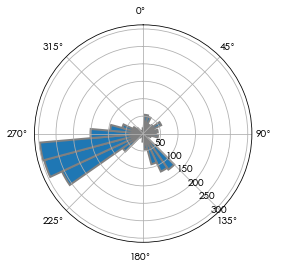

In [6]:
# WD = 0 means WS<0.2m/s --> ignore those values
wind = sa.WD.replace('0', 'NA')
plot_wind(wind, 10)

## Data cleaning and imputation

In [7]:
wd_col = yl.columns[yl.columns.str.match(r'.*WD.*')];wd_col
dict_df = {}
# dfs = [tp, yl, hc]
dfs = [tp, yl, sa]
# dfs = [tp, bq, kl, zzu, ab, yl, sa]
names = ['Taipei', 'Yilan', 'Suao']
# names = ['Taipei', 'Banqiau', 'Keelong']
# names = ['Taipei', 'Banqiau', 'Keelong', 'ZZH', 'ANBU', 'Yilan', 'Suao']
for df, name in zip(dfs, names):

    temp = cleanup_weather(df.copy())
    #Wind direction 0 indicates very low wind speed, mark those as NA
    temp[wd_col] = temp[wd_col].replace(0, 'NA')
    #change wind direction degrees into categories of 8 directions
    cat = temp[wd_col].apply(direction_binning, bin_degree=45)
    #one-hot encode categorical variables (wind direction)
    dummy = pd.get_dummies(cat, dummy_na=True)  #na indicates no wind
    dummy = dummy.loc[:, (dummy != 0).any(axis=0)]
    temp = pd.concat([temp.drop(columns=wd_col), dummy, cat], axis=1)
    dict_df[name] = impute_ExtraTrees(temp)
#     dict_df[name] = temp 

[IterativeImputer] Completing matrix with shape (2175, 37)
[IterativeImputer] Change: 18.123145235892693, scaled tolerance: 1.0335 
[IterativeImputer] Change: 6.460000000000001, scaled tolerance: 1.0335 
[IterativeImputer] Change: 5.439999999999998, scaled tolerance: 1.0335 
[IterativeImputer] Change: 3.8999999999999986, scaled tolerance: 1.0335 
[IterativeImputer] Change: 2.0599999999999987, scaled tolerance: 1.0335 
[IterativeImputer] Change: 2.8200000000000003, scaled tolerance: 1.0335 
[IterativeImputer] Change: 6.840000000000003, scaled tolerance: 1.0335 
[IterativeImputer] Change: 7.82, scaled tolerance: 1.0335 
[IterativeImputer] Change: 2.8000000000000043, scaled tolerance: 1.0335 
[IterativeImputer] Change: 0.9599999999999937, scaled tolerance: 1.0335 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (2175, 37)
[IterativeImputer] Change: 7.398271889400924, scaled tolerance: 1.036 
[IterativeImputer] Change: 0.0, scaled tolera

In [8]:
dict_df.keys()
# dict_df['Taipei'].columns.difference(dict_df['Banqiau'].columns)
# ind1 = dict_df['Tamsui'].index
# ind2 = dict_df['Taipei'].index
# ind2.difference(ind1)

dict_keys(['Taipei', 'Yilan', 'Suao'])

### remove unused columns

In [9]:
weather = pd.concat(dict_df, axis=1)

drop = weather.columns[weather.columns.get_level_values(1).str.match(r'^WDGust')]
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.match(r'^WD')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.match(r'Stn')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.match(r'^Td dew point$')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.startswith('T ')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.match('RHMin')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.match('PresDif')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.match('GloblRad')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.endswith('RHDif')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.endswith('TempDif')])
drop = drop.append(weather.columns[weather.columns.get_level_values(1).str.startswith('PrecpH')])

imputed = weather.drop(columns=drop).copy()
imputed.columns = ['{1}_{0}'.format(*c) for c in imputed.columns]

imputed.info(verbose=True)

# imputed.to_csv('imputed.csv')
# imputed = pd.read_csv('imputed.csv')

# imputed['date'] =  pd.to_datetime(imputed['date'], format='%Y-%m-%d')
# imputed.set_index('date', drop=True, inplace=True)

# imputed.columns = imputed.columns.str.split('_', expand=True)
# imputed = imputed.swaplevel(axis=1)

# imputed.drop(columns='_merge', inplace=True)

# cmax(200)
# imputed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2175 entries, 2015-01-01 to 2020-12-14
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temperature_Taipei   2175 non-null   float64
 1   RH_Taipei            2175 non-null   float64
 2   WS_Taipei            2175 non-null   float64
 3   WSGust_Taipei        2175 non-null   float64
 4   Precp_Taipei         2175 non-null   float64
 5   PrecpMax60_Taipei    2175 non-null   float64
 6   SunShineRate_Taipei  2175 non-null   float64
 7   Temperature_Yilan    2175 non-null   float64
 8   RH_Yilan             2175 non-null   float64
 9   WS_Yilan             2175 non-null   float64
 10  WSGust_Yilan         2175 non-null   float64
 11  Precp_Yilan          2175 non-null   float64
 12  PrecpMax60_Yilan     2175 non-null   float64
 13  SunShineRate_Yilan   2175 non-null   float64
 14  Temperature_Suao     2175 non-null   float64
 15  RH_Suao             

## Try PCA without standardization (standard scaling)

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=0.9)
pca_result = pca.fit_transform(imputed)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.54688339 0.21509983 0.08112235 0.06092573]


In [11]:
x = pd.DataFrame(data = pca.components_, columns=imputed.columns);x

Temperature_Taipei  RH_Taipei  WS_Taipei  WSGust_Taipei  Precp_Taipei  \
0           -0.053220   0.118084   0.008239       0.016968      0.099026   
1            0.042783   0.017701   0.003491       0.017152      0.139896   
2            0.054022   0.143334  -0.018911      -0.016825      0.659246   
3           -0.019953  -0.085001   0.023814       0.060402      0.306462   

   PrecpMax60_Taipei  SunShineRate_Taipei  Temperature_Yilan  RH_Yilan  \
0           0.024543            -0.456174          -0.045648  0.078261   
1           0.039545             0.200710           0.037681  0.043986   
2           0.269169            -0.405210           0.068827  0.030208   
3           0.087943             0.714959          -0.033928 -0.026679   

   WS_Yilan  ...  Precp_Yilan  PrecpMax60_Yilan  SunShineRate_Yilan  \
0 -0.000494  ...     0.189786          0.050876           -0.542794   
1  0.007941  ...     0.413676          0.117415            0.268003   
2  0.007630  ...     0.283962          0.118280            0.159762   
3  0.005118  ...     0.344770          0.129728           -0.253151   

   Temperature_Suao   RH_Suao   WS_Suao  WSGust_Suao  Precp_Suao  \
0         -0.044907  0.098134  0.003648     0.023036    0.352748   
1          0.037217  0.046750  0.007456     0.029858    0.752240   
2          0.070220  0.002538  0.003508     0.043646   -0.349068   
3         -0.030746 -0.034592  0.004650     0.006662   -0.237217   

   PrecpMax60_Suao  SunShineRate_Suao  
0         0.078780          -0.529233  
1         0.166941           0.276562  
2        -0.041367           0.216518  
3        -0.014447          -0.338397  

[4 rows x 21 columns]

In [12]:
df_pca = pd.DataFrame(data={'pca-one':pca_result[:,0],
                            'pca-two':pca_result[:,1],
                            'pca-three':pca_result[:,2]})
# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
df_pca['pca_3']= pd.qcut(df_pca['pca-three'],10)
df_pca['month'] = imputed.index.month

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

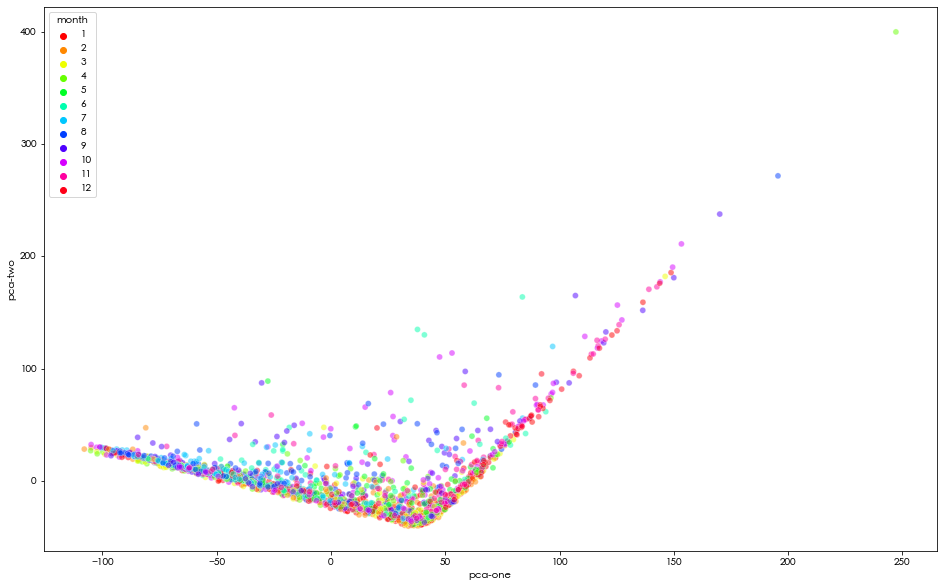

In [13]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",hue='month',
#     palette=sns.color_palette("Spectral", 12),
    palette='hsv',
    data=df_pca,
    legend="full",
    alpha=0.5
)

## PCA after standard scaling

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

imputed_scaled = StandardScaler().fit_transform(imputed)
pca = PCA(n_components=0.9)
pca_result = pca.fit_transform(imputed_scaled)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.30088519 0.19938019 0.14841611 0.08539908 0.05709766 0.05358581
 0.03523366 0.03005822]


In [15]:
x = pd.DataFrame(data = pca.components_, columns=imputed.columns)
# x

In [16]:
df_pca = pd.DataFrame(data={'pca-one':pca_result[:,0],
                            'pca-two':pca_result[:,1],
                            'pca-three':pca_result[:,2]})
# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
df_pca['pca_3']= pd.qcut(df_pca['pca-three'],10)
df_pca['month'] = imputed.index.month

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

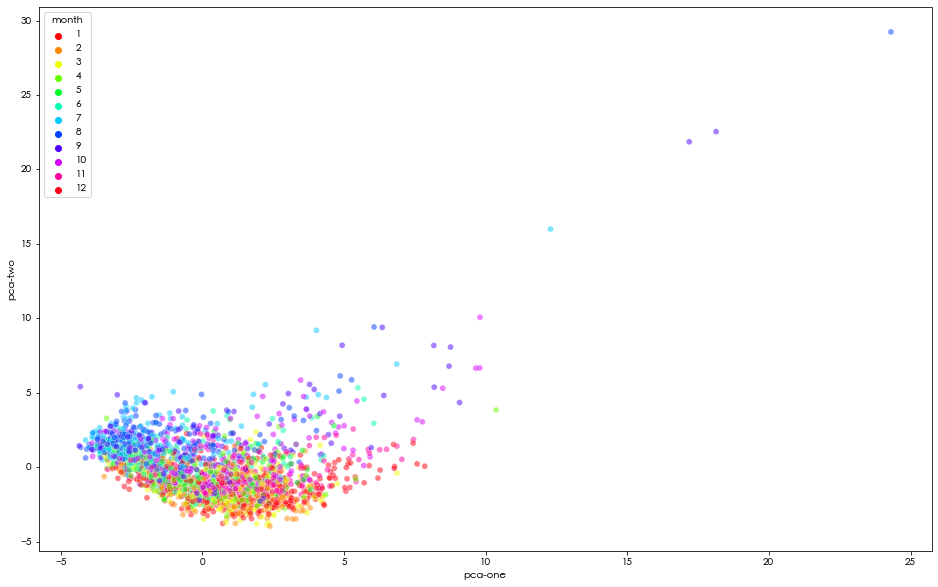

In [17]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",hue='month',
#     palette=sns.color_palette("Spectral", 12),
    palette='hsv',
    data=df_pca,
    legend="full",
    alpha=0.5
)

In [18]:
pca_result.shape, imputed_scaled.shape

((2175, 8), (2175, 21))

## Get historical typhoon data
Get Typhoon data from https://rdc28.cwb.gov.tw/TDB/public/warning_typhoon_list/get_warning_typhoon


In [19]:
url = 'https://rdc28.cwb.gov.tw/TDB/public/warning_typhoon_list/get_warning_typhoon'
headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:71.0) Gecko/20100101 Firefox/71.0', 
           'Accept':'application/json, text/javascript, */*; q=0.01',
           'Accept-Language': 'en-US,en;q=0.5',
           'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
           'X-Requested-With':'XMLHttpRequest',
           'Origin':'https://rdc28.cwb.gov.tw', 
           'DNT':'1',
           'Connetction':'keep-alive',
           'Referer':'https://rdc28.cwb.gov.tw/TDB/public/warning_typhoon_list/'}
# cookies = {'PHPSESSID':'8fenapdmvtib3ftjhnd9s6fvu7', 'TS01b0fe7f':'0107dddfef6e23ed6decf1f7505fd67c9fcd4ce33443bfb213e263ea354912aaa98734383d60bb9ef0badb52568e65ba3e4e676d65'}

# Host: rdc28.cwb.gov.tw
# User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:71.0) Gecko/20100101 Firefox/71.0
# Accept: application/json, text/javascript, */*; q=0.01
# Accept-Language: en-US,en;q=0.5
# Accept-Encoding: gzip, deflate, br
# Content-Type: application/x-www-form-urlencoded; charset=UTF-8
# X-Requested-With: XMLHttpRequest
# Content-Length: 8
# Origin: https://rdc28.cwb.gov.tw
# DNT: 1
# Connection: keep-alive
# Referer: https://rdc28.cwb.gov.tw/TDB/public/warning_typhoon_list/
# Cookie: PHPSESSID=8fenapdmvtib3ftjhnd9s6fvu7; TS01b0fe7f=0107dddfef6e23ed6decf1f7505fd67c9fcd4ce33443bfb213e263ea354912aaa98734383d60bb9ef0badb52568e65ba3e4e676d65
# Pragma: no-cache
# Cache-Control: no-cache

try:
    r = requests.post(url,{
    'year':'all'
    } ,verify=True, headers=headers)
    r.encoding = 'utf-8-sig'
#     r.text
#     table = pd.read_html(r.text, header=None)[1]

except Exception as e:
    print('Error:', e)


In [20]:
js = r.json()
table = pd.DataFrame.from_dict(js)
table['date'] = pd.to_datetime(table['sea_start_datetime'], format='%Y-%m-%d %H:%M:%S')
table['date_end'] = pd.to_datetime(table['sea_end_datetime'], format='%Y-%m-%d %H:%M:%S')
# typhoon = table[(table['date']>=df_num.index.min()) & (table['official_path_category'].isin(['1','2','3','4','6']))] ; typhoon.tail(20)
typhoon = table[(table['date']>=imputed.index.min())] 

In [21]:
typhoon.columns

Index(['id', 'cht_name', 'eng_name', 'official_path_category',
       'sea_start_datetime', 'max_intensity', 'min_pressure', 'max_wind_speed',
       'max_range7', 'max_range10', 'sea_end_datetime', 'warning_count',
       'date', 'date_end'],
      dtype='object')

In [22]:
typ = pd.DataFrame()
for r in typhoon.itertuples(index=False):
    temp = pd.DataFrame(index=pd.date_range(start=r.date, end=r.date_end), 
                        data={'id':r.id, 'cht_name':r.cht_name,'eng_name':r.eng_name, 
                              'path':r.official_path_category, 'max_WS':r.max_wind_speed,
                              'max_range7':r.max_range7, 'max_range10':r.max_range10})
    typ = typ.append(temp)
typ.index = typ.index.date
typ

id cht_name  eng_name path max_WS max_range7 max_range10
2020-11-05  202020       閃電    ATSANI                                   
2020-11-06  202020       閃電    ATSANI                                   
2020-11-07  202020       閃電    ATSANI                                   
2020-08-22  202008       巴威      BAVI          43        220          80
2020-08-10  202006      米克拉  MEKKHALA          23        120            
...            ...      ...       ...  ...    ...        ...         ...
2015-07-09  201509       昌鴻  CHAN-HOM          48        280         100
2015-07-10  201509       昌鴻  CHAN-HOM          48        280         100
2015-07-11  201509       昌鴻  CHAN-HOM          48        280         100
2015-05-10  201506       紅霞      NOUL          51        200          80
2015-05-11  201506       紅霞      NOUL          51        200          80

[69 rows x 7 columns]

In [23]:
idx = typ[typ.index.duplicated(keep='first')].index
typ[typ.index.isin(idx)]

id cht_name eng_name path max_WS max_range7 max_range10
2017-07-29  201710       海棠  HAITANG    7     20        100            
2017-07-30  201710       海棠  HAITANG    7     20        100            
2017-07-29  201709       尼莎    NESAT    2     40        180          60
2017-07-30  201709       尼莎    NESAT    2     40        180          60

In [24]:
typ = typ[~typ.index.duplicated(keep='first')].copy()

In [25]:
typ['path'].replace('', '0', inplace=True)
typ.path.unique()

array(['0', '6', '4', '1', '7', '2', '3'], dtype=object)

In [26]:
# typ = typ[typ.path.isin(['1','2','3','6'])]
typ
typ.to_csv('typhoon_all.csv')

## Load and combine typhoon data

In [27]:
typ = pd.read_csv('typhoon_all.csv', index_col=0, parse_dates=True)
typ.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2020-11-05 to 2015-05-11
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           67 non-null     int64  
 1   cht_name     67 non-null     object 
 2   eng_name     67 non-null     object 
 3   path         67 non-null     int64  
 4   max_WS       64 non-null     float64
 5   max_range7   64 non-null     float64
 6   max_range10  55 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 4.2+ KB


In [28]:
typ.path.unique()

array([0, 6, 4, 1, 7, 2, 3])

In [29]:
combined = imputed.merge(typ, how='left', left_index=True, right_index=True, indicator=True, validate='1:1')

### save dataframe for prediction

In [30]:
weather_save = imputed.merge(typ['path'], how='left', left_index=True, right_index=True, indicator=True, validate='1:1')
weather_save['path'] = weather_save.path.fillna(-1).astype(int)
weather_save['_merge'] = weather_save['_merge'].replace({'left_only':0, 'both':1}).astype(int)

typ_off = pd.read_csv('typhoon_off.csv', index_col=0, parse_dates=True)
weather_save = weather_save.join(typ_off)

weather_save['off'].replace({True:2, False:1, np.nan:0}, inplace=True)

weather_save.rename(columns={'_merge':'seaWarning'}, inplace=True)
# weather_save.to_csv('weather_processed.csv')

### Filter typhoon date by max wind speed threshold

In [31]:
combined['path'].fillna('-1', inplace=True)
# combined['month']= combined.index.month.astype('category')
combined['month'] = combined.index.month

combined['_merge'].cat.as_ordered(inplace=True)
combined['_merge_code'] = combined['_merge'].cat.codes
combined['_merge_code'].replace(0, 0.2, inplace=True)

In [32]:
# combined['WSGust_max'] = combined[['WSGust_Yilan','WSGust_Suao', 'WSGust_Keelong', 'WSGust_ZZH','WSGust_ANBU']].max(axis=1)
combined['WSGust_max'] = combined.loc[:, combined.columns.str.match('WSGust')].max(axis=1)
x = combined.loc[combined.groupby('id')['WSGust_max'].idxmax()]

每秒瞬間風速>17.2 (八級風& 輕度颱風中心風速定義)
or 
每秒瞬間風速>24.5 (十級風)
如果選定測站的最大風速在颱風警報日期內都沒有超過以上值，表示颱風應該未直接登陸影響兩地
每個颱風期間只標記瞬間風速最大的那一日

In [33]:
x['typ']= pd.cut(x.WSGust_max, bins=(0,24.5,99), labels=['normal', 'strong'])
combined = combined.merge(x['typ'], how='left', left_index=True, right_index=True, indicator='_exist')
combined['typ'] = combined['typ'].cat.add_categories("NA").fillna("NA")

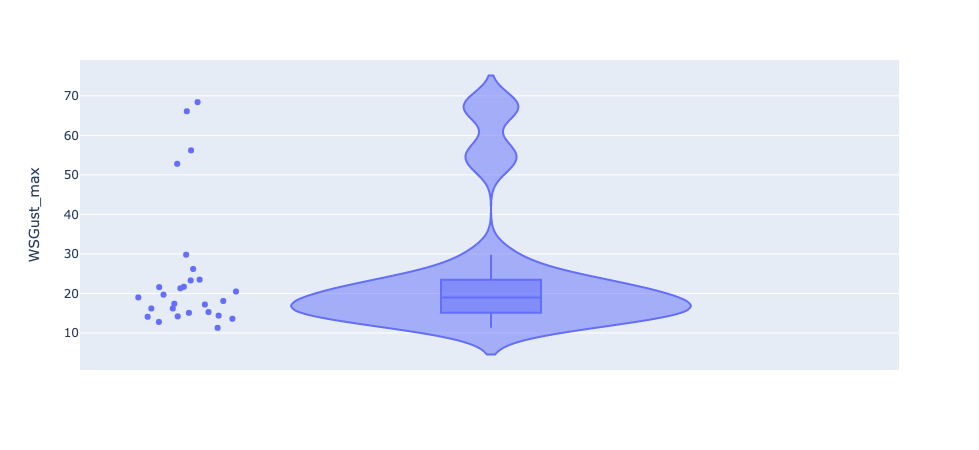

In [34]:
fig = px.violin(x, y="WSGust_max", box=True, # draw box plot inside the violin
                points='all', # can be 'outliers', or False
               )
fig.show()

In [35]:
combined.drop(columns=['_merge', '_merge_code'], inplace=True)
combined['typ'].cat.categories , combined['typ'].unique()

(Index(['normal', 'strong', 'NA'], dtype='object'), ['NA', 'normal', 'strong']
 Categories (3, object): ['normal' < 'strong' < 'NA'])

From pandas doc:
The result of unique() is not always the same as Series.cat.categories, because Series.unique() has a couple of guarantees, namely that it returns categories in the order of appearance, and it only includes values that are actually present.

Make the type of typhoon as numerical for plotting as size variables. 
Only typhoon actually passed will be enlarged. 

In [36]:
combined['typ_code'] = combined['typ'].replace({'NA':0.2, 'normal':0.2, 'strong':2})
combined.typ_code.value_counts()

0.2    2169
2.0       6
Name: typ_code, dtype: int64

## Try TSNE

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=2, perplexity=50, n_iter=500, early_exaggeration=50)
tsne_results = tsne.fit_transform(imputed_scaled)

combined['tsne_1'] = tsne_results[:,0]
combined['tsne_2'] = tsne_results[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2175 samples in 0.003s...
[t-SNE] Computed neighbors for 2175 samples in 0.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2175
[t-SNE] Computed conditional probabilities for sample 2000 / 2175
[t-SNE] Computed conditional probabilities for sample 2175 / 2175
[t-SNE] Mean sigma: 1.059168
[t-SNE] Computed conditional probabilities in 0.091s
[t-SNE] Iteration 50: error = 406.8703918, gradient norm = 1.0253707 (50 iterations in 0.870s)
[t-SNE] Iteration 100: error = 411.1236267, gradient norm = 0.9986342 (50 iterations in 0.904s)
[t-SNE] Iteration 150: error = 415.4877319, gradient norm = 0.9857193 (50 iterations in 1.036s)
[t-SNE] Iteration 200: error = 415.2387695, gradient norm = 0.9900920 (50 iterations in 1.325s)
[t-SNE] Iteration 250: error = 415.4352417, gradient norm = 0.9803073 (50 iterations in 1.141s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 415.435242
[t-SNE] Iteration 30

In [37]:
rmax(500)
cmax(500)
combined.head(500)

NameError: name 'rmax' is not defined

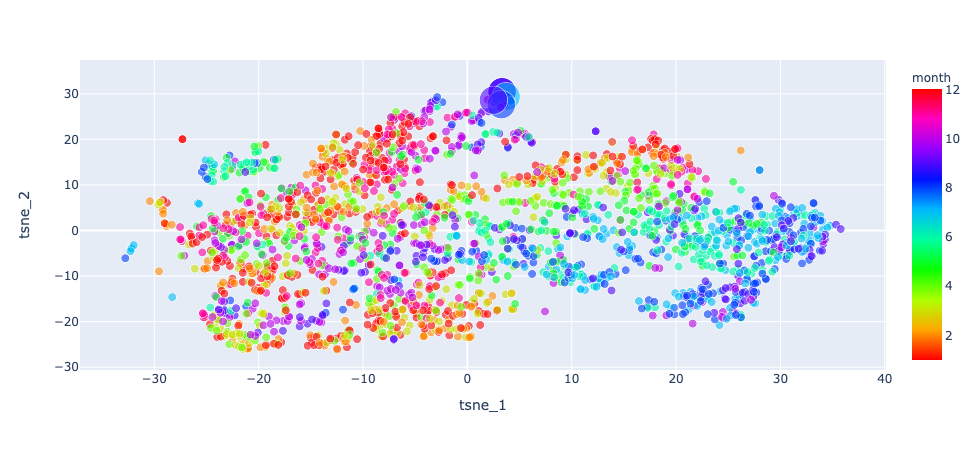

In [38]:
select_col = combined.columns[combined.columns.str.startswith(
    ('Temperature', 'RH', 'WS', 'Precp', 'SunShine', 'GloblRad', 'max_WS')
    )]
# select_col
fig = px.scatter(combined.reset_index(), x='tsne_1', y='tsne_2', hover_name='date',color='month', size='typ_code',
                hover_data = select_col,
                color_continuous_scale=px.colors.cyclical.HSV, 
                opacity=0.6)

fig.show()

# ['index', 'StnPres', 'SeaPres', 'StnPresMax', 'StnPresMin', 'Temperature', 'T Max', 'T Min', 'Td dew point', 'RH', 'RHMin', 'WS', 'WD', 'WSGust', 'WDGust', 'Precp', 'PrecpHour', 'PrecpMax10', 'PrecpHrMax', 'SunShine', 'SunShineRate', 'GloblRad', 'VisbMean', 'EvapA', 'UVI Max', 'Cloud Amount', 'id', 'cht_name', 'eng_name', 'path', 'max_WS', 'max_range7', 'max_range10', '_merge', 'tsne_1', 'tsne_2'] but received: temp

In [ ]:
fig.write_image('test.png')

In [235]:
exa = 30
for p in range(5,210,10):
    

    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=1000, early_exaggeration=exa)
    tsne_results = tsne.fit_transform(imputed_scaled)

    combined['tsne_1'] = tsne_results[:,0]
    combined['tsne_2'] = tsne_results[:,1]

    #select_col = combined.columns[combined.columns.str.startswith(('Temperature', 'RH', 'WS', 'WSGust', 'Precp', 'SunShine', 'VisbMean','Cloud Amount'))]
    fig = px.scatter(combined, x='tsne_1', y='tsne_2',color='month', size='typ_code',
                    #hover_data=['Temperature', 'RH', 'WS', 'WSGust', 'Precp', 'SunShine', 'VisbMean','Cloud Amount','cht_name', 'path','max_WS'],
                    #hover_data = select_col,
                    color_continuous_scale=px.colors.cyclical.HSV, 
                    opacity=0.6)

#     fig.show()
    fname = f'perplexity_{p:03}_exag_{exa:02}' + '.png'
    fig.write_image(fname)

# ['index', 'StnPres', 'SeaPres', 'StnPresMax', 'StnPresMin', 'Temperature', 'T Max', 'T Min', 'Td dew point', 'RH', 'RHMin', 'WS', 'WD', 'WSGust', 'WDGust', 'Precp', 'PrecpHour', 'PrecpMax10', 'PrecpHrMax', 'SunShine', 'SunShineRate', 'GloblRad', 'VisbMean', 'EvapA', 'UVI Max', 'Cloud Amount', 'id', 'cht_name', 'eng_name', 'path', 'max_WS', 'max_range7', 'max_range10', '_merge', 'tsne_1', 'tsne_2'] but received: temp

In [ ]:
fname = f'perplexity_{i:03}_exag_{i:02}' + '.png' ; fname

In [ ]:
import plotly.io as pio
import plotly

pio.orca.shutdown_server()
pio.orca.status

In [ ]:
plotly.io.orca.config

In [39]:
imputed_scaled.shape

(2175, 21)